# PSD to Pandas structurd featuer generation

In [17]:
# Input
### PSD
# Dict PSD paramter ( nfft, range, window ...)
# freq band cut in and cut off

### pick files
# Dict Case slect ( SNR, device, ID optinal * , scale) - use to pick filse
# file count limter - maximum files per normal and abnorml to create from
# Case select always normal and abnormal
#



# Output
# pandas FRame 
# columns = freq band 
# Valus = PSD Power ( based on scale optin)
# target column = normal or abnormal ( 0,1)
# one row is one wav file
# SNR, ID, Device Name
#




In [82]:
import scipy.signal as sig
import numpy as np
import librosa
import pandas as pd

import os
import sys
import glob

In [83]:
def get_files(base_folder,SNR,machine,ID):
    
    fn = dict()
    fa = dict()
    
    for idx in ID:
        
        fn[idx] = sorted(glob.glob(os.path.abspath( "{base}/{SNR}/{machine}/id_{ID}/{n}/*.{ext}".format(
        base=base_folder+'dataset',SNR=SNR,machine='pump',ID=idx, n='normal',ext='wav' ))))
    
        fa[idx] = sorted(glob.glob(os.path.abspath( "{base}/{SNR}/{machine}/id_{ID}/{n}/*.{ext}".format(
        base=base_folder+'dataset',SNR=SNR,machine='pump',ID=idx, n='abnormal',ext='wav' ))))
    
    return fn, fa
    

In [41]:
n, a = get_files('../../','6dB','pump',['00'])
n['00'][0]
#import re

'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\6dB\\pump\\id_00\\normal\\00000000.wav'

In [48]:
import re
a =re.search('\\|/',n['00'][0])
os.path.split(n['00'][0])[1]
os.path.basename(n['00'][0]).replace('.'+'wav','')

'00000000'

In [20]:
os.path.abspath('../../')

'A:\\Dev\\NF_Prj_MIMII_Dataset'

In [167]:
import copy 

def PSD_to_Pandas(PSD_window='hamming',
                  PSD_nperseg = 128,
                  PSD_nfft=512,
                  PSD_scaling='spectrum',
                  freq_band = [0,16000],
                  base_folder = './',
                  FileFindDict={'SNR': '6dB',
                                'machine': 'pump', 
                                'ID': ['00']},
                  ChannelNr=0,
                  FileCountlimit=None):
    
    # get file path
    nf, af = get_files(base_folder,
                       FileFindDict['SNR'],
                       FileFindDict['machine'],
                       FileFindDict['ID'])
    
    # limit the File count
    for idx in nf:
        if FileCountlimit:
            if FileCountlimit < len(nf[idx]):
                nf[idx] = nf[idx][:FileCountlimit]
            if FileCountlimit < len(af[idx]):
                af[idx] = af[idx][:FileCountlimit]
     
    # create base pandas
    real_base_folder = os.path.abspath(base_folder)
    df = pd.DataFrame(columns=['path','abnormal','ID'])
    
    get_filename = lambda l: [os.path.basename(pl).replace('.'+'wav','') for pl in l]
     
    for idx in nf:
        df_temp_n = pd.DataFrame()
        df_temp_n['path'] = nf[idx]
        df_temp_n['file'] = get_filename(nf[idx])
        df_temp_n['abnormal'] = 0
        df_temp_n['ID'] = idx
        df_temp_a = pd.DataFrame()
        df_temp_a['path'] = af[idx]
        df_temp_a['file'] = get_filename(af[idx])
        df_temp_a['abnormal'] = 1
        df_temp_a['ID'] = idx
        df = df.append(df_temp_n, ignore_index = True) 
        df = df.append(df_temp_a, ignore_index = True) 
    
    df['machine'] = FileFindDict['machine']
    df['SNR'] = FileFindDict['SNR']
    
    
    # create the psd columns
    first_loop = True
    for i in df.index:
        file_path = df.iloc[i]['path']
        #print(file_path)
        audio_ch, sr = librosa.load(file_path, sr=None, mono=False)
        f, Pxx = sig.welch(audio_ch[ChannelNr],sr,
                           window=PSD_window,
                           nperseg=PSD_nperseg, 
                           noverlap=False, 
                           nfft=PSD_nfft,
                           scaling=PSD_scaling)
        
             
        
        if first_loop:
            first_loop = False
            if freq_band[0] > 0:
                idx_s = np.min(np.where(f>freq_band[0]))
            else:
                idx_s = 0
                
            if freq_band[1] < np.max(f):
                idx_e = np.min(np.where(f>freq_band[1]))
            else:
                idx_e = len(f)
                
            # basic matrix    
            ff = f[idx_s:idx_e]    
            PSDmatrix = np.zeros([len(df.index),len(ff)])
            
       
        for iF,Pi in enumerate(Pxx[idx_s:idx_e]):
             PSDmatrix[i,iF]=Pi
            
        # Debug Print    
        #plt.plot(f[idx_s:idx_e], PSDmatrix[i,:]) #Pxx[idx_s:idx_e])
        #ax = plt.gca()
        #ax.set_xscale('log')
        #ax.set_yscale('log')

    #for i in df.index:
    #    plt.plot(f[idx_s:idx_e], PSDmatrix[i,:]) #Pxx[idx_s:idx_e])
    #    ax = plt.gca()
    #    ax.set_xscale('log')
    #    ax.set_yscale('log')
        
    df_psd = pd.DataFrame(columns=ff,data=PSDmatrix)
    # make path relativ to project
    get_relpath = lambda pl: os.path.join(pl.replace(real_base_folder, ''))
    df['path'] = df['path'].apply(get_relpath)
    return pd.concat([df,df_psd], axis=1)
 
    
test = PSD_to_Pandas(base_folder='../../', FileFindDict={'SNR': '6dB',
                                'machine': 'pump', 
                                'ID': ['00','02']}, FileCountlimit=2, freq_band = [250,8000])
test

,path,abnormal,ID,file,machine,SNR,281.25,312.5,343.75,375.0,...,7718.75,7750.0,7781.25,7812.5,7843.75,7875.0,7906.25,7937.5,7968.75,8000.0
0,\dataset\6dB\pump\id_00\normal\00000000.wav,0,00,00000000,pump,6dB,0.000002,0.000002,0.000001,0.000001,...,5.316734e-08,4.912297e-08,4.514861e-08,4.101670e-08,3.675315e-08,3.258964e-08,2.884488e-08,2.584378e-08,2.388666e-08,1.160220e-08
1,\dataset\6dB\pump\id_00\normal\00000001.wav,0,00,00000001,pump,6dB,0.000002,0.000002,0.000001,0.000001,...,4.854261e-08,4.483064e-08,4.085615e-08,3.666346e-08,3.244671e-08,2.848889e-08,2.507934e-08,2.246389e-08,2.082307e-08,1.013221e-08
2,\dataset\6dB\pump\id_00\abnormal\00000000.wav,1,00,00000000,pump,6dB,0.000029,0.000037,0.000048,0.000062,...,4.517074e-08,4.133590e-08,3.718712e-08,3.320077e-08,2.989242e-08,2.733657e-08,2.534281e-08,2.386696e-08,2.299404e-08,1.135868e-08
3,\dataset\6dB\pump\id_00\abnormal\00000001.wav,1,00,00000001,pump,6dB,0.000035,0.000043,0.000054,0.000068,...,4.473755e-08,4.015247e-08,3.629624e-08,3.326083e-08,3.091763e-08,2.887451e-08,2.686202e-08,2.505697e-08,2.384380e-08,1.171471e-08
4,\dataset\6dB\pump\id_02\normal\00000000.wav,0,02,00000000,pump,6dB,0.000003,0.000003,0.000002,0.000002,...,1.865858e-08,1.714843e-08,1.574062e-08,1.448340e-08,1.338165e-08,1.244305e-08,1.170618e-08,1.121265e-08,1.095512e-08,5.439989e-09
5,\dataset\6dB\pump\id_02\normal\00000001.wav,0,02,00000001,pump,6dB,0.000003,0.000003,0.000002,0.000002,...,1.606125e-08,1.465257e-08,1.324852e-08,1.197656e-08,1.090001e-08,1.003180e-08,9.364737e-09,8.892671e-09,8.612502e-09,4.259987e-09
6,\dataset\6dB\pump\id_02\abnormal\00000000.wav,1,02,00000000,pump,6dB,0.000003,0.000003,0.000002,0.000002,...,1.862271e-08,1.721689e-08,1.539155e-08,1.334535e-08,1.144856e-08,1.013563e-08,9.624008e-09,9.746248e-09,1.008159e-08,5.121502e-09
7,\dataset\6dB\pump\id_02\abnormal\00000001.wav,1,02,00000001,pump,6dB,0.000003,0.000002,0.000002,0.000001,...,2.135694e-08,1.961825e-08,1.794653e-08,1.623309e-08,1.453071e-08,1.312088e-08,1.226297e-08,1.194299e-08,1.191713e-08,5.969856e-09


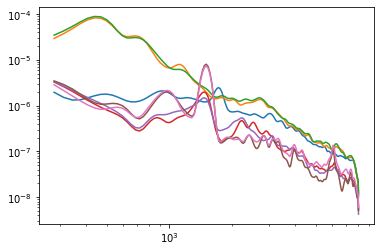

In [159]:
import matplotlib.pyplot as plt
for idx in [1,2,3,4,5,6,7]:
    signal = test.iloc[idx, :]
    plt.plot(signal.index,signal.values)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

In [132]:
m = np.zeros([4,3])
m[3,0] = 2
m

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [2., 0., 0.]])

0
1
1
0


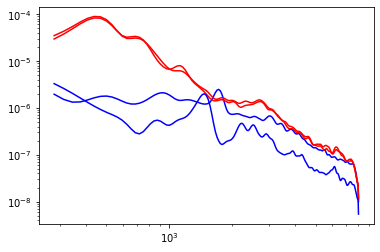

In [168]:
# spot check the data 
import matplotlib.pyplot as plt
for idx in [1,2,3,4]:
    aORn = test.iloc[idx,1]
    print(aORn)
    signal = test.iloc[idx, 6:]
    c = 'blue'
    if aORn:
        c = 'red'
    plt.plot(signal.index,signal.values, color=c)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

In [38]:
a = np.array([0, 15.0, 28.0, 32.1, 66])

np.min(np.where(a>15))
np.min(np.where(a>32)

(array([3, 4], dtype=int64),)

## example 1 - pump 6dB - 1 IDs